In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import json
from keras.models import load_model
import pandas as pd
from scipy.stats import pearsonr
from keras.utils.generic_utils import get_custom_objects
from losses import neg_log_likelihood
from util import partition_data, get_balaji_predictions, get_experimental_X_y, get_gfp_X_y_aa
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')

/global/homes/d/dbrookes/myconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
ALL_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHODS = [ 'cbas', 'rwr', 'fbvae', 'dbas', 'cem-pi', 'killoran', 'bombarelli', 'bombarelli-unconstrained']
METHOD_COLORS = {METHODS[i]: ALL_COLORS[i] for i in range(len(METHODS))}
METHOD_COLORS['bombarelli-unconstrained'] = ALL_COLORS[len(METHODS) + 1]

In [6]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [7]:
def plot_sorted_samples():
    fig = plt.figure(figsize=(4, 3))
    suffix = '_hetero_1'
    methods = ['cbas', 'rwr']
    for j in range(len(methods)):
        method = methods[j]
        oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix)).flatten()
        gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix)).flatten()
        sorted_idx = np.argsort(oracle_samples)
        sorted_oracle = oracle_samples[sorted_idx]
        sorted_gt = gt_samples[sorted_idx]
        x = range(len(sorted_idx))
        plt.xlabel("Sorted Index")
        plt.ylabel("$y$")
        plt.plot(range(len(sorted_oracle)), sorted_oracle,c=METHOD_COLORS[method], ls='--', lw=1, label="%s Oracle" % method.upper())
        plt.scatter(range(len(sorted_gt)), sorted_gt, s=0.5, c=METHOD_COLORS[method], label="%s GT" % method.upper(), alpha=0.5)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.tight_layout()
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.savefig('toy_setup.png', dpi=500)
    plt.show()

In [9]:
def plot_traj(quantile=0.8, sort=True, mean=False, use_first=50, sub=True):
    for i in range(1, 4):
        for j in range(1):
            fig = plt.figure(figsize=(4, 3))
            suffix = '_5k_%i_%i' %(i, j)
            if use_first > 100:
                suffix += "_long"
            if sub:
                methods = [ 'cbas', 'fbvae']
            else:
                methods = [ 'cbas', 'fbvae', 'rwr', 'dbas', 'cem-pi']
            for k in range(len(methods)):
                method = methods[k]
                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[:use_first]
                
                if mean:
                    oracle_vals= np.mean(oracle_samples, axis=1)
                    gt_vals = np.mean(gt_samples, axis=1)
                else:
                    per = np.percentile(oracle_samples, quantile*100, axis=-1)
                    per = per.reshape(oracle_samples.shape[0], 1)
                    oracle_idxs = np.where(oracle_samples > per)
                    
                    oracle_vals = np.zeros_like(oracle_samples)
                    oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
                    oracle_vals = np.true_divide(oracle_vals.sum(1),(oracle_vals!=0).sum(1))
                    
                    gt_vals = np.zeros_like(gt_samples)
                    gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
                    gt_vals = np.true_divide(gt_vals.sum(1),(gt_vals!=0).sum(1))
                
                x = range(oracle_samples.shape[0])
                if sort:
                    sorted_idx = np.argsort(oracle_vals)
                else:
                    sorted_idx = range(len(x))
                    
                lbl = method.upper()
                if method == 'cbas':
                    lbl = 'CbAS'
                elif method == 'dbas':
                    lbl = 'DbAS'
                    
                print(method, np.max(gt_vals[~np.isnan(gt_vals)]))
                plt.plot(x, gt_vals[sorted_idx], c=METHOD_COLORS[method], label="%s" % lbl, zorder=len(methods)-j)
                plt.plot(x, oracle_vals[sorted_idx], c=METHOD_COLORS[method], ls='--', zorder=len(methods)-j)

            plt.ylabel("$%i^{th}$ percentile of $y$ samples" % int(quantile*100))
            plt.xlabel("Iteration (sorted by oracle values)")
            plt.legend(frameon=True, loc='lower left')
            plt.grid(True)
            plt.gca().set_axisbelow(True)
            plt.gca().grid(color='gray', alpha=0.2)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')
            if sub:
                plt_name = "plots/traj_%.1f_%i_%i_sub.png" % (quantile, i, j)
            else:
                plt_name = "plots/traj_%.1f_%i_%i_all.png" % (quantile, i, j)
            print(plt_name)
            plt.tight_layout()
            plt.savefig(plt_name, dpi=500)
            plt.show()

cbas 3.3227808214436827
fbvae 3.2467968836215846
rwr 3.2791534090499175
dbas 3.2871418706416278
cem-pi 3.2893875818527776
plots/traj_0.8_1_0_all.png


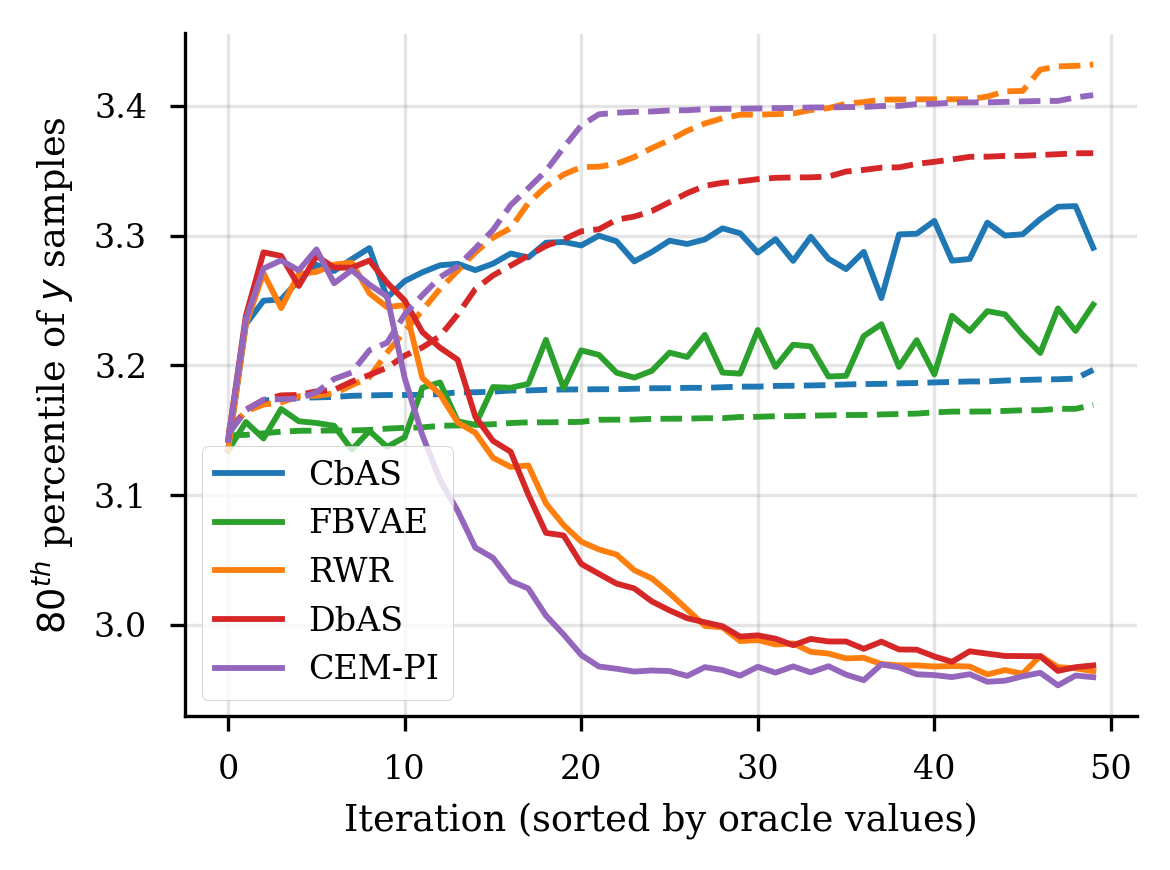

cbas 3.329958158937253
fbvae 3.2547671736671218
rwr 3.3551573025964214
dbas 3.3682751589624056
cem-pi 3.3100152567557104
plots/traj_0.8_2_0_all.png


/global/homes/d/dbrookes/myconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/global/homes/d/dbrookes/myconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


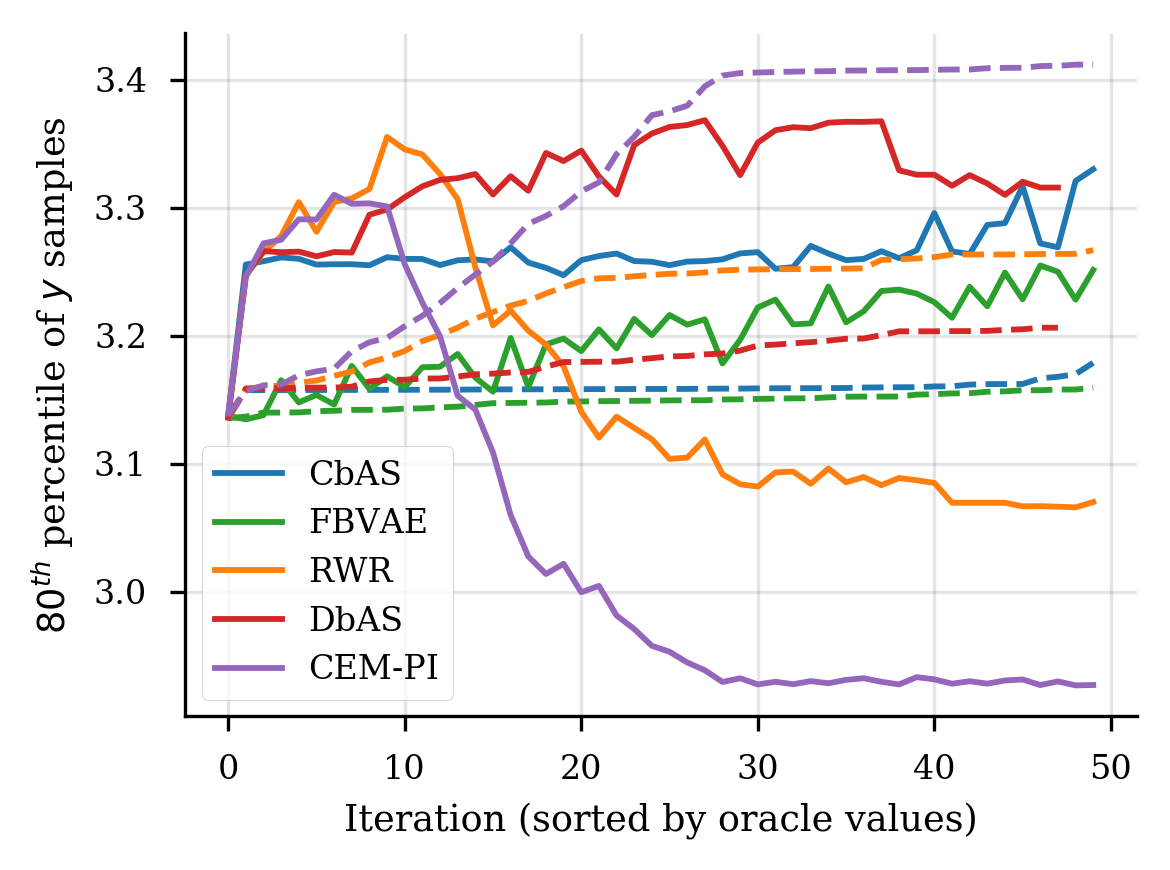

cbas 3.3305550782877473
fbvae 3.2718281784429606
rwr 3.351034930115945
dbas 3.3970425135169355
cem-pi 3.29820304128233
plots/traj_0.8_3_0_all.png


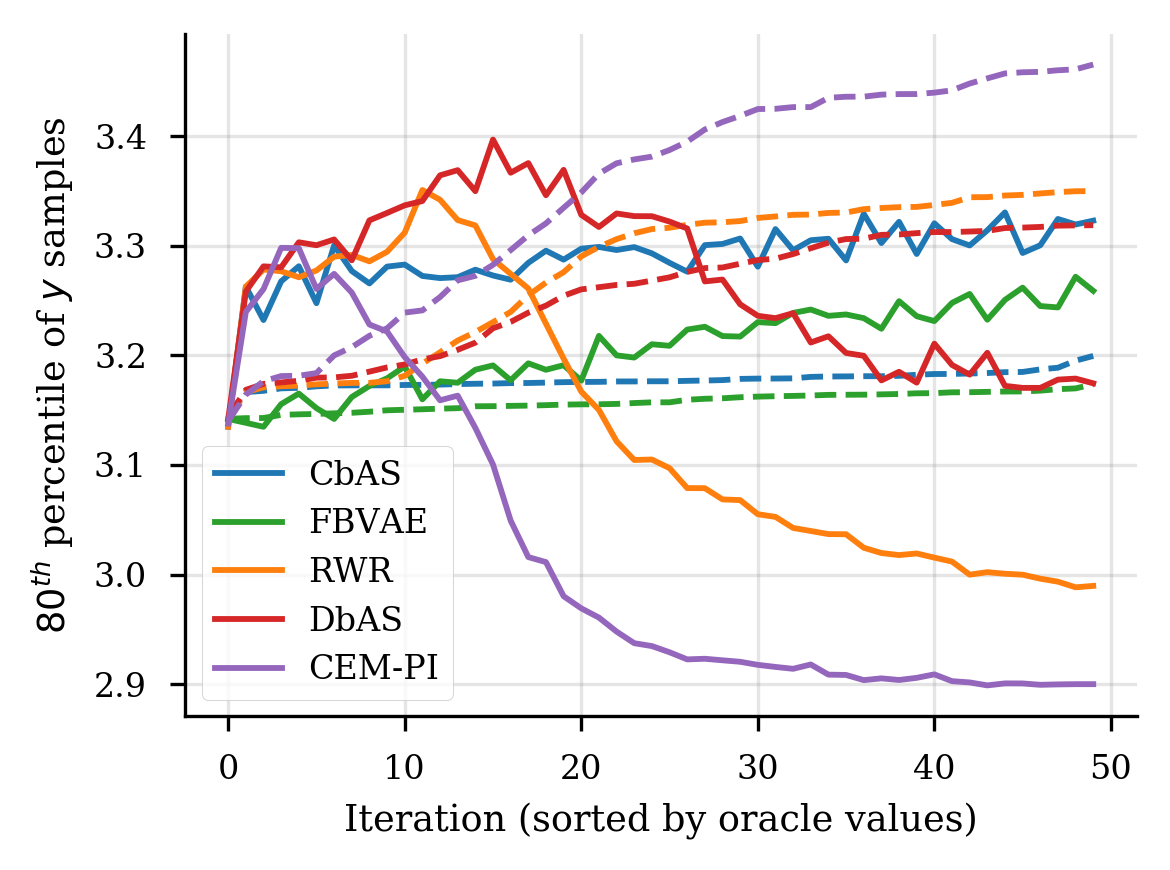

In [10]:
plot_traj(quantile=0.8, sort=True, mean=False, use_first=50, sub=False)

In [11]:
def plot_comparison(quantiles, mean=False, use_first=50):
    repeats = 3
    fig = plt.figure(figsize=(4, 3))
    width = 0.25
    ml_methods = ['cbas', 'fbvae', 'dbas', 'rwr', 'cem-pi']
    all_methods = deepcopy(ml_methods)
    include_killoran_bomb = True
    total = len(ml_methods)
    if include_killoran_bomb:
        total += 3
        all_methods += ['bombarelli', 'bombarelli-unconstrained', 'killoran']
    shades = [0.4, 0.6, 0.8, 1]
    results = np.zeros((len(quantiles), total, repeats))
    for i in range(1, 4):  # Loop over random state
        for k in range(repeats):
            suffix = '_5k_%i_%i' % (i, k)
            for j in range(len(ml_methods)):
                method = ml_methods[j]
                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[:use_first]

                oracle_samples = oracle_samples.flatten()
                gt_samples = gt_samples.flatten()
                for l in range(len(quantiles)):
                    quantile = quantiles[l]
                    top_oracle_idxs = np.where(oracle_samples >= np.percentile(oracle_samples, quantile*100))
                    gt_at_top_oracle = gt_samples[top_oracle_idxs]
                    results[l, j, k] = np.mean(gt_at_top_oracle)
                    
        if include_killoran_bomb:
            killoran_results = np.load("results/killoran_results_5k_%i.npy" % i)
            bombarelli_results = np.load("results/bombarelli_results_5k_%i.npy" % i)
            bombarelli_results2 = np.load("results/bombarelli_results_unconstrained_5k_%i.npy" % i)
            results[l, len(ml_methods), :] = bombarelli_results[1]
            results[l, len(ml_methods)+1, :] = bombarelli_results2[1]
            results[l, len(ml_methods)+2, :] = killoran_results[1]

        xs = range(total)
        xs = [xi + i*width for xi in xs]
        for j in range(total):
            for l in range(len(quantiles)):
                method = all_methods[j]
                c = METHOD_COLORS[method]
                val = results[l, j].mean(axis=-1)
                if i == 1 and j == 0:
                    lbl = "$%i^{th}$ Percentile" % int(100*quantiles[l])
                else:
                    lbl=None
                if l == 0:
                    plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), 
                            edgecolor='k', linewidth=0.5, label=lbl, zorder=l+1)
                else:
                    prev_val = results[l-1, j].mean(axis=-1)
                    plt.bar(xs[j],val-prev_val, width=width, 
                            bottom = prev_val,
                            color=lighten_color(c, shades[l]), edgecolor='k', 
                            linewidth=0.5, label=lbl, zorder=l+1)
        prev_results = results

    plt.xticks([i + 2*width for i in range(total)])
    all_lbls = [ml_methods[j].upper() for j in range(len(ml_methods))]
    for i in range(len(all_lbls)):
        if all_lbls[i] == 'CBAS':
            all_lbls[i] = 'CbAS'
        elif all_lbls[i] == 'DBAS':
            all_lbls[i] = 'DbAS'
        elif all_lbls[i] == 'KILLORAN':
            all_lbls[i] = 'Killoran'
            
    if include_killoran_bomb:
        all_lbls += ['GB', 'GB-NO', 'AM-VAE']
    plt.gca().set_xticklabels(all_lbls, rotation=60)
    y_label = "Ground Truth Values"
    
    plt.ylabel(y_label)
    plt.ylim([2.85, 3.4])
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    
    plt.legend(fontsize=5, frameon=True, loc='upper right')
    leg = plt.gca().get_legend()
    for l in range(len(quantiles)):
        leg.legendHandles[l].set_color(lighten_color(ALL_COLORS[7], shades[l]))
        leg.legendHandles[l].set_edgecolor('k')
    plt.tight_layout()
    plt.savefig("plots/compare_results.png", dpi=500)
    plt.show()
            

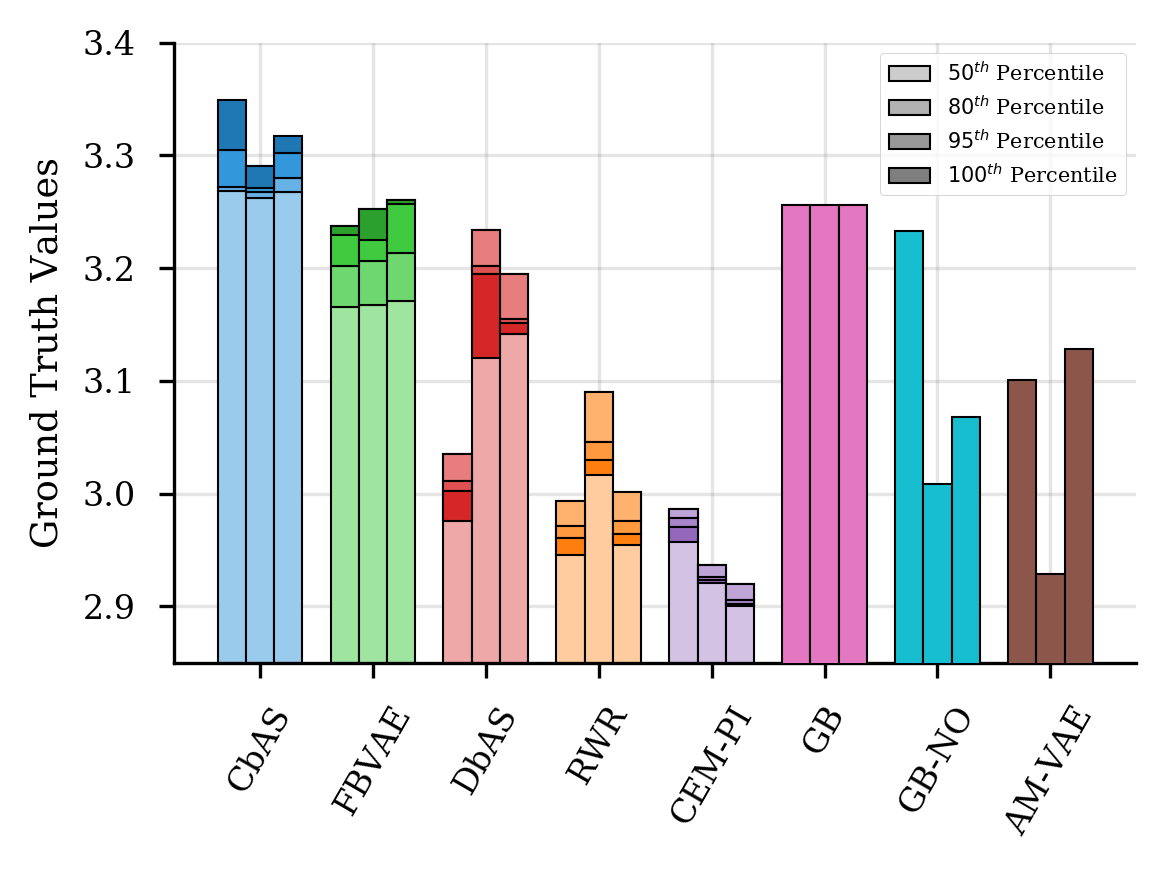

In [12]:
plot_comparison(quantiles=[0.5, 0.8, 0.95, 1], mean=False, use_first=50)

In [13]:
def gather_sequences():
    methods = [ 'cbas', 'fbvae', 'rwr', 'dbas', 'cem-pi']
    seqs = {'method':[], 'seq':[]}
    for method in methods:
        for i in range(1, 4):
            for j in range(3):
                suffix = '_5k_%i_%i' %(i, j)
                f = 'results/%s_max%s.json' % (method, suffix)
                seqs['method'].append(method)
                with open(f) as outfile:
                    data = json.load(outfile)
                    seqs['seq'].append(data['oracle_max_seq'])
                    
    methods=['bombarelli','bombarelli_unconstrained', 'killoran']    
    for method in methods:
        for i in range(1, 4):
            suffix = '_5k_%i' % i
            seqs['method'].append(method)
            if method == 'bombarelli_unconstrained':
                suffix = '_unconstrained' + suffix
                f = 'results/%s_max%s.json' % ('bombarelli', suffix)
            else:
                f = 'results/%s_max%s.json' % (method, suffix)
            with open(f) as outfile:
                data = json.load(outfile)
                seqs['seq'].append(data['oracle_max_seq'][0])
    
    df = pd.DataFrame(seqs)
    return df
                

In [15]:
def make_stability_table():
    df = pd.read_csv("results/GFP_Rosetta_ddG_predicted.csv")
    method_map = {'dbas': 'DbAS', 'cbas': 'CbAS', 'rwr': 
                  'RWR', 'cem-pi': 'CEM-PI', 'fbvae': 'FBVAE',
                 'bombarelli': 'GB', 'bombarelli_unconstrained': 'GB-NO', 
                 'killoran': 'AM-VAE'}
    print(df[['method', 'ddG (kcal/mol)', 'Num Mutations introduced']])
    df['method'] = df['method'].map(method_map)
    summary = df[['method', 'ddG (kcal/mol)', 'Num Mutations introduced']].groupby('method').mean().reset_index()
    summary = summary.sort_values('ddG (kcal/mol)')
    print(summary)
    

In [ ]:
def make_oracle_paired_plots():
    for it in range(1):
        fig = plt.figure(figsize=(4, 3))
        TRAIN_SIZE = 5000
        train_size_str = "%ik" % (TRAIN_SIZE/1000)
        RANDOM_STATE = it + 1
        
        loss = neg_log_likelihood
        get_custom_objects().update({"neg_log_likelihood": loss})
        
        df = pd.read_csv('data/gfp_data.csv')
        X_all, _ = get_gfp_X_y_aa(df, large_only=True, ignore_stops=True)
        y_all = np.load("data/gfp_gt_evals.npy")
        perc = np.percentile(y_all, 20)
        above_idx = np.where(y_all > perc)[0]
        X_above, y_above = X_all[above_idx], y_all[above_idx]
        
        X_train, y_train, gt_train, X_test, y_test, gt_test  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE, return_test=True)
        num_models = [1, 5, 20][it]
        oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
        oracles = [load_model("models/oracle_%i%s.h5" % (i, oracle_suffix)) for i in range(num_models)]
        
        y_pred, _ = get_balaji_predictions(oracles, X_test)
        y_pred_above, _ = get_balaji_predictions(oracles, X_above)
        
        plt.scatter(y_test, y_pred, s=1, label="$< 20^{th}$ percentile")
        plt.scatter(y_above, y_pred_above, s=1, label="$\geq 20^{th}$ percentile")
        plt.plot((2.9, 3.5), (2.9, 3.5), c='k', ls='--')
        plt.ylim([2.95, 3.5])
        plt.xlim([2.95, 3.5])
        plt.xlabel("Ground Truth Values")
        plt.ylabel("Mean Oracle Predictions")
        plt.legend(markerscale=3)
        plt.grid(True)
        plt.gca().set_axisbelow(True)
        plt.gca().grid(color='gray', alpha=0.2)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().yaxis.set_ticks_position('left')
        plt.gca().xaxis.set_ticks_position('bottom')
        plt.tight_layout()
        plt.savefig("plots/paired_plot_%i.png" % (it+1), dpi=500)
        plt.show()
        plt.close()
        

In [ ]:
make_oracle_paired_plots()

In [ ]:
def plot_q_test_results(quantile=0.8, sort=True, mean=False, use_first=50, sub=True):
    fig = plt.figure(figsize=(4, 3))
    qs = [0.5, 0.75, 0.95, 1.0]
    for k in range(len(qs)):
        q = qs[k]
        suffix = '_5k_1_%.2f' % q
        oracle_samples = np.load("results/cbas_oracle_samples_qtest%s.npy" % suffix)[:use_first]
        gt_samples = np.load("results/cbas_gt_samples_qtest%s.npy" % suffix)[:use_first]

        if mean:
            oracle_vals= np.mean(oracle_samples, axis=1)
            gt_vals = np.mean(gt_samples, axis=1)
        else:
            per = np.percentile(oracle_samples, quantile*100, axis=-1)
            per = per.reshape(oracle_samples.shape[0], 1)
            oracle_idxs = np.where(oracle_samples > per)

            oracle_vals = np.zeros_like(oracle_samples)
            oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
            oracle_vals = np.true_divide(oracle_vals.sum(1),(oracle_vals!=0).sum(1))

            gt_vals = np.zeros_like(gt_samples)
            gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
            gt_vals = np.true_divide(gt_vals.sum(1),(gt_vals!=0).sum(1))

        x = range(oracle_samples.shape[0])
        if sort:
            sorted_idx = np.argsort(oracle_vals)
        else:
            sorted_idx = range(len(x))

        plt.plot(x, gt_vals[sorted_idx], c=cm(k/len(qs)), label="$Q = %.2f$" % q)
        plt.plot(x, oracle_vals[sorted_idx], c=cm(k/len(qs)), ls='--')

    plt.ylabel("$%i^{th}$ percentile of $y$ samples" % int(quantile*100))
    plt.xlabel("Iteration (sorted by oracle values)")
    plt.legend(frameon=True, loc='upper left')
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    plt.savefig("plots/qtest.png", dpi=500)
    plt.show()

In [ ]:
plot_q_test_results()